In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import math 
import numpy as np
import unicodedata
import re
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device :", device)

device : cuda


In [2]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # every words get unique index
        self.word2count = {} # count of every particular words in the dataset
        self.index2word = {0: "SOS", 1: "EOS", 2:"PAD"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2):
    df_original = pd.read_csv('/kaggle/input/eng-fr/eng_-french.csv')
    df = df_original.sample(frac=1).reset_index(drop=True) # suffeling the dataset

    lines = df.apply(lambda row: f"{row['English words/sentences']}@@@{row['French words/sentences']}", axis=1).tolist()

    # Spliting every line into pairs and normalizing
    pairs = [[normalizeString(s) for s in l.split('@@@')] for l in lines]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs



def filterPair(p):
    return len(p[0].split(' ')) < 68 and \
        len(p[1].split(' ')) < 68 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [3]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Word counts:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('English', 'French')

Read 175621 sentence pairs
Word counts:
English 13913
French 22851


In [4]:
seq_len = 68
def indexes_from_sentence(lang, sentence):
    idxs = [lang.word2index[word] for word in sentence.split(' ')]
    idxs.append(EOS_token)
    idxs.insert(SOS_token,0)
    return idxs
    
def batch_from_pairs(pairs):
    batch_inp = [indexes_from_sentence(input_lang, p[0]) for p in pairs]
    batch_inp = [seq+[PAD_token]*(seq_len-len(seq)) for seq in batch_inp]
    input_tensor = torch.tensor(batch_inp, dtype=torch.long, device=device)
    
    batch_trg = [indexes_from_sentence(output_lang, p[1]) for p in pairs]
    batch_trg = [seq+[PAD_token]*(seq_len-len(seq)) for seq in batch_trg]
    target_tensor = torch.tensor(batch_trg, dtype=torch.long, device=device)    
    
    return input_tensor,target_tensor

In [5]:
# Configurations
n_layers = 5
d_model = 128
n_heads = 8
d_heads = d_model//n_heads

def attention(q,k,v,dropout,mask=None):
    b,h,l,dk = q.size()
    x = torch.matmul(q,k.transpose(-2,-1)) / dk**0.5
    
    if mask is not None:
        x= x.masked_fill(mask==0,-1e9)
    x = x.softmax(dim=-1)
    x = dropout(x)    
    x = torch.matmul(x,v)
    return x

class MultiHeaderAttention(nn.Module):
    def __init__(self,d_model,dropout,n_heads=n_heads, dk=d_heads,dv=d_heads):
        super(MultiHeaderAttention,self).__init__()
        self.dims = dk,dv,n_heads
        self.q = nn.Linear(d_model, dk*n_heads)
        self.k = nn.Linear(d_model, dk*n_heads)
        self.v = nn.Linear(d_model, dv*n_heads)
        self.dropout = nn.Dropout(p=dropout)

        self.out = nn.Linear(dv*n_heads, d_model)
            
    def forward(self,k,v,q,mask=None):
        b,len_k,len_q,len_v = k.size(0), k.size(1), q.size(1), v.size(1)
        dk,dv,h =self.dims
        q = self.q(q).view(b,len_q,h,dk).transpose(1,2)
        k = self.k(k).view(b,len_k,h,dk).transpose(1,2)
        v = self.v(v).view(b,len_v,h,dk).transpose(1,2)
        if mask is not None:
            mask = mask.unsqueeze(1) #put header dim for broadcasting
            
        x = attention(q,k,v, self.dropout, mask)
        x = x.transpose(1,2).contiguous().view(b,len_q,h*dk) # swap headers and seq_len
        return self.out(x)

In [6]:
class PositionEncoding(nn.Module):
    def __init__(self,max_len,d_model):
        super(PositionEncoding,self).__init__()
        self.max_len = max_len+5
        self.register_buffer('pos_table', self.tensor_pos_encoding(self.max_len, d_model))

    def pos_encoding(self,pos, k):
        """taking an vocab index and generating a a geometric progression with k dimensions """
        f = lambda i,k: pos / 10000**(2 * (i // 2) / k)
        return [math.sin(f(i,k)) if i%2==0 else math.cos(f(i,k)) for i in range(0,k)]

    def tensor_pos_encoding(self,max_len,dim):
        return torch.tensor([self.pos_encoding(i,dim) for i in range(max_len)],device=device).view( max_len,dim)

    def forward(self,x):
        return x+ self.pos_table[:x.size(1),:].detach().clone().unsqueeze(0)

In [7]:
# Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, size, dropout):
        super(ResidualConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class Encoder(nn.Module):
    def __init__(self, n_input_vocab, d_model,n_hidden,n_layers,dropout):
        super().__init__()
        self.d_model = d_model
        
        self.embedding = nn.Embedding(n_input_vocab,d_model,padding_idx=PAD_token)
        self.dropout = nn.Dropout(p=dropout)
        self.normal = nn.LayerNorm(d_model, eps=1e-6)   
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, n_hidden,dropout) for i in range(n_layers)]
            )

        self.pos_enc = PositionEncoding(seq_len,d_model)

        
    def forward(self,x,mask):
        x = self.embedding(x) * self.d_model**0.5
        x = self.pos_enc(x)
        
        #stack of N  identical layers
        for layer in self.encoder_layers:
            x = layer(x,mask)
        return self.normal(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_hidden,dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = attn = MultiHeaderAttention(d_model,dropout)
        self.feed_forward = nn.Sequential(
                        nn.Linear(d_model,n_hidden), 
                        nn.ReLU(),
                        nn.Dropout(p=dropout),
                        nn.Linear(n_hidden,d_model) 
        )
        self.sublayer = nn.ModuleList([ResidualConnection(d_model, dropout) for i in range(2)])

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [9]:
class Decoder(nn.Module):
    def __init__(self,n_target_vocab,d_model, n_hidden,n_layers,dropout):
        super().__init__()
        self.d_model = d_model
        
        self.embedding = nn.Embedding(n_target_vocab,d_model,padding_idx=PAD_token)
        self.dropout = nn.Dropout(p=dropout)
        self.normal = nn.LayerNorm(d_model, eps=1e-6)
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, n_hidden,dropout) for i in range(n_layers)]
            )
            
        self.pos_enc = PositionEncoding(seq_len,d_model)
        
    def forward(self,x,encoder_outputs,self_attn_mask, enc_dec_mask):
        x = self.embedding(x)*self.d_model**0.5
        x = self.pos_enc(x)
        
        #stack of N identical layers
        for layer in self.decoder_layers:
            x = layer(x,encoder_outputs,self_attn_mask, enc_dec_mask)
        
        return self.normal(x)
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_hidden,dropout):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeaderAttention(d_model,dropout)
        self.src_attn = MultiHeaderAttention(d_model,dropout)
        self.feed_forward = nn.Sequential(
                        nn.Linear(d_model,n_hidden), 
                        nn.ReLU(),
                        nn.Dropout(p=dropout),
                        nn.Linear(n_hidden,d_model) 
        )
        self.sublayer = nn.ModuleList([ResidualConnection(d_model, dropout) for i in range(3)])

    def forward(self, x, memory, tgt_mask,src_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(m, m, x,src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [10]:
class Transformer(nn.Module):
    def __init__(self,d_model, n_input_vocab,n_target_vocab, n_hidden,n_layers,dropout):
        super().__init__()

        self.encoder = Encoder(n_input_vocab, d_model, n_hidden, n_layers, dropout)
        self.decoder = Decoder(n_target_vocab, d_model, n_hidden, n_layers,dropout)
        self.out = nn.Linear(d_model, n_target_vocab)  
        
    def get_target_mask(self, target_seq):
        b_sz, len_s = target_seq.size()
        return torch.tril(torch.ones(len_s,len_s,device=device)).bool().expand(1,len_s,len_s)

    def get_pad_mask(self,seq):
        return (seq != PAD_token).unsqueeze(-2)   
    
    def forward(self,input_seq, target_seq):
        trg_mask = self.get_pad_mask(target_seq)
        trg_mask = trg_mask & self.get_target_mask(target_seq).type_as(trg_mask.data)
        inp_mask = self.get_pad_mask(input_seq)

        encoder_out = self.encoder(input_seq,inp_mask)
        decoder_out = self.decoder(target_seq,encoder_out,trg_mask,inp_mask)
        
        out = self.out(decoder_out)
        return out


# for 5 encoder and 5 decoder blocks

In [11]:
#splitting the data into train and test datasets
l = len(pairs)
train = pairs[:int(l*0.7)] # 70% of whole data
test = pairs[int(l*0.7):] # 30% for testing
val = train[int(len(train)*0.85):] # 15% of training data


#the model with the parameter-values of the paper
transformer1 = Transformer(d_model=d_model, 
                            n_input_vocab=input_lang.n_words, 
                            n_target_vocab= output_lang.n_words,
                            n_hidden = 225,
                            n_layers=n_layers, 
                            dropout=0.1).to(device)

transformer1 = nn.DataParallel(transformer1)

for p in transformer1.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [12]:
# Adam optimizer 
lr= 1
opt1 = optim.Adam(transformer1.parameters(),lr=lr)

def lr_rate(step_num, d_model, factor, warmup_steps):
    step_num =max(1,step_num)
    return factor * (
        d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))
    )

lr_scheduler = LambdaLR(
    optimizer=opt1,
    lr_lambda=lambda step_num: lr_rate(
        step_num, 512, factor=1, warmup_steps=4000
    ),
)

In [13]:
def pred(input_seq, model):
    outputs = [SOS_token]
    
    for i in range(seq_len):
        target_seq = torch.tensor([outputs],device=device)
        output = model(input_seq,target_seq)
        probs = F.softmax(output,dim=2)
        word_pred = torch.argmax(probs[:,-1,:],dim=1)

        outputs.append(word_pred.item())

        if word_pred.item()== EOS_token:
            break
    
    return outputs[1:]

In [14]:
def train_batch(input_seq, target_seq, model, optimizer,scheduler):
    target, truth = target_seq[:,:-1], target_seq[:,1:]
    pred = model(input_seq,target)
    
    loss = F.cross_entropy(pred.view(-1,output_lang.n_words), truth.reshape(-1),label_smoothing=0.1) # this is mean of loss for each tokens
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    return loss.item()

In [15]:
epochs = 200
batch_sz = 100

def compute_accuracy(model, validation_data, e):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(validation_data), batch_sz):
            input_tensor_val, output_tensor_val = batch_from_pairs(validation_data[i:i + batch_sz])
            target, truth = output_tensor_val[:,:-1], output_tensor_val[:,1:]
            
            outputs = model(input_tensor_val, target)
            outputs = outputs.view(-1,output_lang.n_words)
            _, predicted = torch.max(outputs, 1)
            
            # masking the paded data
            mask = (truth.reshape(-1) != 2)
            total += truth.reshape(-1)[mask].size(0)

            correct += (predicted[mask] == truth.reshape(-1)[mask]).sum().item()
   
    return correct / total


training_loss = []
validation_accu = []
for epoch in range(epochs):
    train_loss = 0
    count = 0
    
    # Training
    for i in range(0, len(train), batch_sz):
        input_tensor, output_tensor = batch_from_pairs(train[i:i + batch_sz])
        loss = train_batch(input_tensor, output_tensor, transformer1, opt1, lr_scheduler)
        train_loss += loss
        count += 1
        
    # Validation 
    training_loss.append(train_loss/count)
    validation_accuracy = compute_accuracy(transformer1, val, epoch)
    validation_accu.append(validation_accuracy)
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training loss: {round(train_loss / count, 2)} | Validation accuracy: {(round(validation_accuracy, 2))*100}% | Learning rate: {round(lr_scheduler.get_last_lr()[0], 6)}")

Epoch 1/200 | Training loss: 4.96 | Validation accuracy: 18.0% | Learning rate: 0.000215
Epoch 2/200 | Training loss: 1.87 | Validation accuracy: 44.0% | Learning rate: 0.00043
Epoch 3/200 | Training loss: 1.69 | Validation accuracy: 61.0% | Learning rate: 0.000645
Epoch 4/200 | Training loss: 1.58 | Validation accuracy: 70.0% | Learning rate: 0.00063
Epoch 5/200 | Training loss: 1.53 | Validation accuracy: 74.0% | Learning rate: 0.000564
Epoch 6/200 | Training loss: 1.5 | Validation accuracy: 77.0% | Learning rate: 0.000514
Epoch 7/200 | Training loss: 1.48 | Validation accuracy: 79.0% | Learning rate: 0.000476
Epoch 8/200 | Training loss: 1.47 | Validation accuracy: 80.0% | Learning rate: 0.000446
Epoch 9/200 | Training loss: 1.46 | Validation accuracy: 82.0% | Learning rate: 0.00042
Epoch 10/200 | Training loss: 1.45 | Validation accuracy: 83.0% | Learning rate: 0.000398
Epoch 11/200 | Training loss: 1.44 | Validation accuracy: 83.0% | Learning rate: 0.00038
Epoch 12/200 | Training 

In [16]:
torch.save(transformer1.state_dict(), "transformer_model-4.pth")

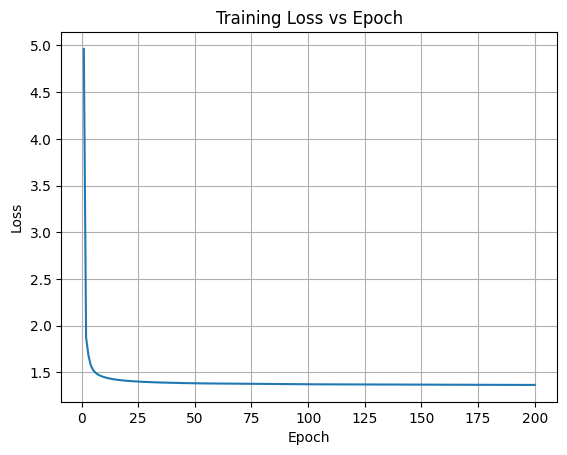

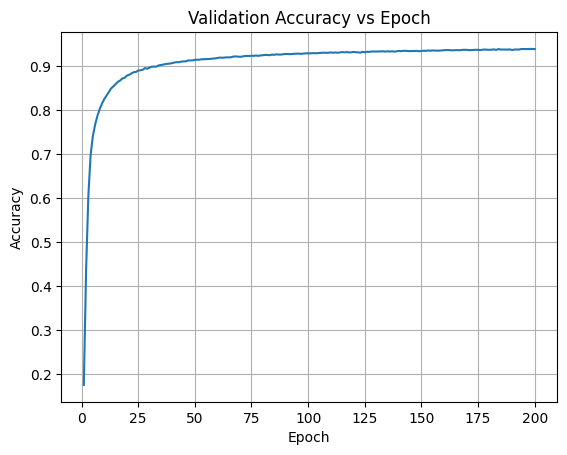

In [17]:
import matplotlib.pyplot as plt

# Plot loss versus epoch
plt.plot(range(1, epochs + 1), training_loss)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_loss_plot-4.png') 
plt.show()

# Plot loss versus epoch
plt.plot(range(1, epochs + 1), validation_accu)
plt.title('Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('validation_accuracy_plot-4.png')
plt.show()

# Testing

In [18]:
batch_sz = 64
correct = 0
total = 0
# loading the model
transformer1.load_state_dict(torch.load("transformer_model-4.pth"))
transformer1.eval() 

with torch.no_grad():
    for i in range(0, len(test), batch_sz):
        input_tensor_test, output_tensor_test = batch_from_pairs(test[i:i + batch_sz])
        target, truth = output_tensor_test[:,:-1], output_tensor_test[:,1:]

        outputs = transformer1(input_tensor_test, target)
        outputs = outputs.view(-1,output_lang.n_words)
        _, predicted = torch.max(outputs, 1)

        mask = (truth.reshape(-1) != 2)
        total += truth.reshape(-1)[mask].size(0)
        correct += (predicted[mask] == truth.reshape(-1)[mask]).sum().item()

print(f"Test accuracy: {(round(correct / total, 2))*100}%")

Test accuracy: 78.0%
